In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport utils, GroupingAlgorithm

%matplotlib widget

/home/dfernandez/anaconda3/envs/heem/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings

from qiskit import IBMQ

from utils import molecules, Label2Chain, get_backend_connectivity, number_cnots_raw
from GroupingAlgorithm import grouping, groupingWithOrder

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')

In [8]:
name_backend = 'ibmq_montreal'
backend_device = provider.get_backend(name_backend)
WC_device = get_backend_connectivity(backend_device)
G_device = nx.Graph()
G_device.add_edges_from(WC_device)

In [45]:
n_qubits = {'H2': 2, 'LiH': 4, 'BeH2': 6, 'H2O': 8, 'CH4': 10, 'C2H2': 16, 'CH3OH': 22}
n_paulis = {'H2': 5, 'LiH': 100, 'BeH2': 95, 'H2O': 444, 'CH4': 1191, 'C2H2': 1884, 'CH3OH': 9257}

# Number of groups

In [61]:
n_groups_TPB = {'H2': 2, 'LiH': 25, 'BeH2': 24, 'H2O': 93, 'CH4': 246, 'C2H2': 457, 'CH3OH': 2225}
n_groups_EM = {'H2': 2, 'LiH': 11, 'BeH2': 15, 'H2O': 51, 'CH4': 113, 'C2H2': 189, 'CH3OH': 682}
n_groups_HEEM = {'H2': 2, 'LiH': 10, 'BeH2': 13, 'H2O': 47, 'CH4': 117, 'C2H2': 258, 'CH3OH': 1503}

n_groups = [n_groups_TPB, n_groups_EM, n_groups_HEEM]

TPB: 0.9323468149479588
EM: 0.7930291644974384
HEEM: 0.8887550794650356


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
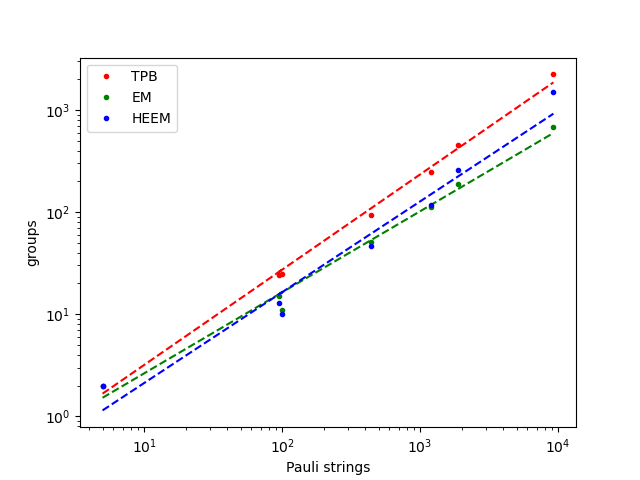

In [63]:
fig, ax = plt.subplots()

x_data = list(n_qubits.values())
scaling_groups = []

colors = ['r', 'g', 'b']
labels = ['TPB', 'EM', 'HEEM']
molecules = ['H2', 'LiH', 'BeH2', 'H2O', 'CH4', 'C2H2', 'CH3OH']

# x_data = [n_qubits[molecule] for molecule in molecules]
x_data = [n_paulis[molecule] for molecule in molecules]

for i in range(3):
    y_data = [n_groups[i][molecule] for molecule in molecules]
    ax.plot(x_data, y_data, '.', c=colors[i], label=labels[i])
    
    alpha, beta = np.polyfit(np.log(x_data), np.log(y_data), 1)
    scaling_groups.append(alpha)
    
    ax.plot(x_data, np.exp(beta) * x_data ** alpha, '--', c=colors[i])
    
    print(f'{labels[i]}: {scaling_groups[i]}')
    
# ax.set_xlabel('qubits')
ax.set_xlabel('Pauli strings')

ax.set_ylabel('groups')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend();

# Number of CNOTs (TODO: include CH3OH)

In [32]:
n_cnots_EM = {'H2': 1, 'LiH': 8, 'BeH2': 74, 'H2O': 563, 'CH4': 2677, 'C2H2': 8969}
n_cnots_HEEM = {'H2': 1, 'LiH': 8, 'BeH2': 18, 'H2O': 80, 'CH4': 224, 'C2H2': 433}

n_cnots = [n_cnots_EM, n_cnots_HEEM]

EM: 1.9465515249885221
HEEM: 1.1936410293528086


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
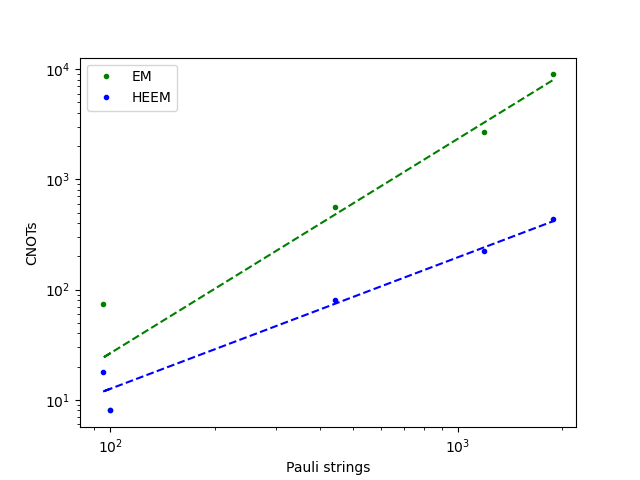

In [52]:
fig, ax = plt.subplots()

x_data = list(n_qubits.values())
scaling_cnots = []

colors = ['g', 'b']
labels = ['EM', 'HEEM']
molecules = ['LiH', 'BeH2', 'H2O', 'CH4', 'C2H2']

# x_data = [n_qubits[molecule] for molecule in molecules]
x_data = [n_paulis[molecule] for molecule in molecules]

for i in range(2):
    y_data = [n_cnots[i][molecule] for molecule in molecules]
    ax.plot(x_data, y_data, '.', c=colors[i], label=labels[i])
    
    alpha, beta = np.polyfit(np.log(x_data), np.log(y_data), 1)
    scaling_cnots.append(alpha)
    
    ax.plot(x_data, np.exp(beta) * x_data ** alpha, '--', c=colors[i])
    
    print(f'{labels[i]}: {scaling_cnots[i]}')
    
# ax.set_xlabel('qubits')
ax.set_xlabel('Pauli strings')

ax.set_ylabel('CNOTs')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend();

# Grouping time

In [26]:
n_grouping_time_TPB = {'H2': 110 * 10 ** -6, 'LiH': 35 * 10 ** -3, 'BeH2': 32.7 * 10 ** -3, 
                       'H2O': 718 * 10 ** -3, 'CH4': 5.18, 'C2H2': 13.1, 'CH3OH': 7.5 * 60}
n_grouping_time_EM = {'H2': 480 * 10 ** -6, 'LiH': 38.7 * 10 ** -3, 'BeH2': 38.9 * 10 ** -3, 
                      'H2O': 793 * 10 ** -3, 'CH4': 6.31, 'C2H2': 17.6, 'CH3OH': 15.5 * 60}
n_grouping_time_HEEM = {'H2': 544 * 10 ** -6, 'LiH': 38.5 * 10 ** -3, 'BeH2': 43.7 * 10 ** -3, 
                        'H2O': 861 * 10 ** -3, 'CH4': 7.32, 'C2H2': 24, 'CH3OH': 24.2 * 60}

n_grouping_time = [n_grouping_time_TPB, n_grouping_time_EM, n_grouping_time_HEEM]

TPB: 2.066909665241711
EM: 2.177762354254662
HEEM: 2.2614523132894027


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
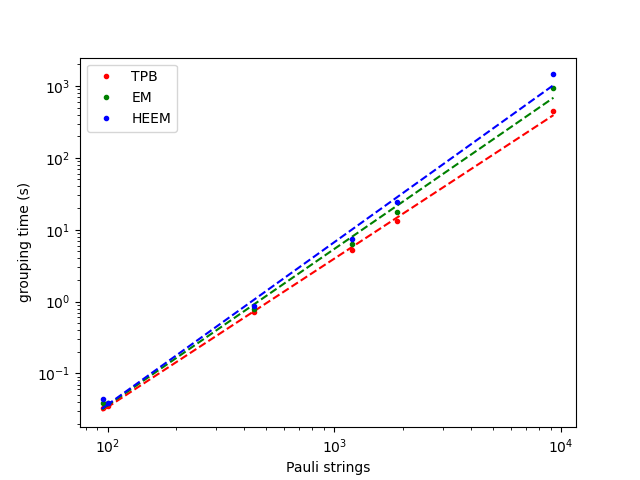

In [53]:
fig, ax = plt.subplots()

scaling_grouping_time = []

colors = ['r', 'g', 'b']
labels = ['TPB', 'EM', 'HEEM']
molecules = ['LiH', 'BeH2', 'H2O', 'CH4', 'C2H2', 'CH3OH']

# x_data = [n_qubits[molecule] for molecule in molecules]
x_data = [n_paulis[molecule] for molecule in molecules]

for i in range(3):
    y_data = [n_grouping_time[i][molecule] for molecule in molecules]
    ax.plot(x_data, y_data, '.', c=colors[i], label=labels[i])
    
    alpha, beta = np.polyfit(np.log(x_data), np.log(y_data), 1)
    scaling_grouping_time.append(alpha)
    
    ax.plot(x_data, np.exp(beta) * x_data ** alpha, '--', c=colors[i])
    
    print(f'{labels[i]}: {scaling_grouping_time[i]}')
    
# ax.set_xlabel('qubits')
ax.set_xlabel('Pauli strings')

ax.set_ylabel('grouping time (s)')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend();

# Simulation time

In [39]:
n_simulation_TPB = {'H2': 0.224, 'LiH': 1.8, 'BeH2': 1.8, 'H2O': 6, 'CH4': 67.5, 'C2H2': 86.9 + 52.8, 'CH3OH': 1475 * 60}
n_simulation_EM = {'H2': 0.159, 'LiH': 0.839, 'BeH2': 1.1, 'H2O': 2.7, 'CH4': 47.4, 'C2H2': 83.1, 'CH3OH': 3063 * 60}
n_simulation_HEEM = {'H2': 0.155, 'LiH': 0.733, 'BeH2': 1.3, 'H2O': 2.7, 'CH4': 11, 'C2H2': 116.1, 'CH3OH': 372 * 60}

n_simulation_time = [n_simulation_TPB, n_simulation_EM, n_simulation_HEEM]

In [70]:
for i in range(3):
    y_data = np.array(list(n_simulation_time[i].values())) / 60
    print(y_data)

[3.73333333e-03 3.00000000e-02 3.00000000e-02 1.00000000e-01
 1.12500000e+00 2.32833333e+00 1.47500000e+03]
[2.65000000e-03 1.39833333e-02 1.83333333e-02 4.50000000e-02
 7.90000000e-01 1.38500000e+00 3.06300000e+03]
[2.58333333e-03 1.22166667e-02 2.16666667e-02 4.50000000e-02
 1.83333333e-01 1.93500000e+00 3.72000000e+02]


TPB: 3.1925773908109134
EM: 3.6928880889420954
HEEM: 3.081858495839243


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
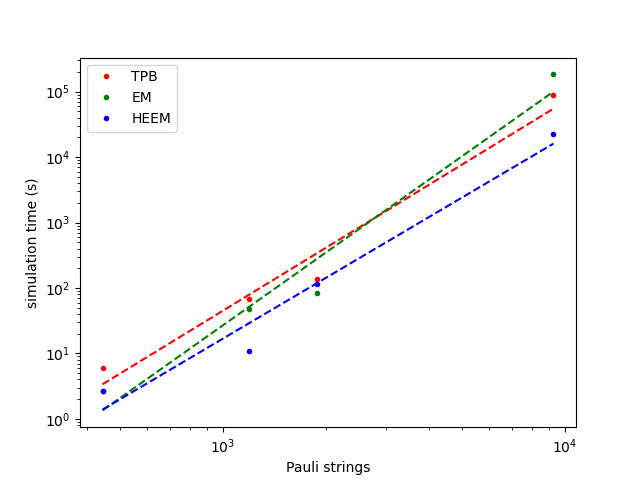

In [55]:
fig, ax = plt.subplots()

x_data = list(n_qubits.values())
scaling_simulation_time = []

colors = ['r', 'g', 'b']
labels = ['TPB', 'EM', 'HEEM']
molecules = ['H2O', 'CH4', 'C2H2', 'CH3OH']

# x_data = [n_qubits[molecule] for molecule in molecules]
x_data = [n_paulis[molecule] for molecule in molecules]

for i in range(3):
    y_data = [n_simulation_time[i][molecule] for molecule in molecules]
    ax.plot(x_data, y_data, '.', c=colors[i], label=labels[i])
    
    alpha, beta = np.polyfit(np.log(x_data), np.log(y_data), 1)
    scaling_simulation_time.append(alpha)
    
    ax.plot(x_data, np.exp(beta) * x_data ** alpha, '--', c=colors[i])
    
    print(f'{labels[i]}: {scaling_simulation_time[i]}')
    
# ax.set_xlabel('qubits')
ax.set_xlabel('Pauli strings')

ax.set_ylabel('simulation time (s)')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend();

# Error

In [57]:
error_TPB = {'H2': 2.04, 'LiH': 3.13, 'BeH2': 10.65, 'H2O': 17.15, 'CH4': 38.56, 'C2H2': 52.8, 'CH3OH': 47.3}
error_EM = {'H2': 0.31, 'LiH': 2.1, 'BeH2': 1.86, 'H2O': 12.7, 'CH4': 32.78, 'C2H2': 46.4, 'CH3OH': 79.1}
error_HEEM = {'H2': 0.3, 'LiH': 2.04, 'BeH2': 3.17, 'H2O': 15.92, 'CH4': 14.17, 'C2H2': 43.7, 'CH3OH': 43.9}

error_simulation = [error_TPB, error_EM, error_HEEM]

TPB: 0.3711776229239952
EM: 0.8320576597079817
HEEM: 0.5770961939562307


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
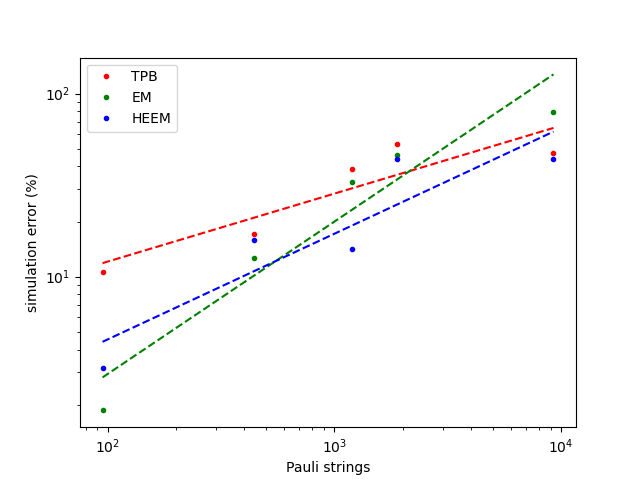

In [60]:
fig, ax = plt.subplots()

x_data = list(n_qubits.values())
scaling_simulation_time = []

colors = ['r', 'g', 'b']
labels = ['TPB', 'EM', 'HEEM']
molecules = ['BeH2', 'H2O', 'CH4', 'C2H2', 'CH3OH']

# x_data = [n_qubits[molecule] for molecule in molecules]
x_data = [n_paulis[molecule] for molecule in molecules]

for i in range(3):
    y_data = [error_simulation[i][molecule] for molecule in molecules]
    ax.plot(x_data, y_data, '.', c=colors[i], label=labels[i])
    
    alpha, beta = np.polyfit(np.log(x_data), np.log(y_data), 1)
    scaling_simulation_time.append(alpha)
    
    ax.plot(x_data, np.exp(beta) * x_data ** alpha, '--', c=colors[i])
    
    print(f'{labels[i]}: {scaling_simulation_time[i]}')
    
# ax.set_xlabel('qubits')
ax.set_xlabel('Pauli strings')

ax.set_ylabel('simulation error (%)')

ax.set_yscale('log')
ax.set_xscale('log')

ax.legend();